# <center> RTK Morphology Analysis </center>



## Step 1: Import Necessary Libraries

The first step is to import the libraries you'll need. In this case, we're using Pandas to work with data and NumPy (although not used in this specific example). You can import these libraries as follows:

In [ ]:
import pandas as pd
import numpy as np
import pyrsktools
import os
import math
from os import walk
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import plotly.express as px
import geopandas
import geodatasets
import contextily as cx
import plotly.graph_objects as go
from scipy.interpolate import griddata
from convertbng.util import convert_bng, convert_lonlat



## Step 2: Load Data from a CSV File

To load data from a CSV file into a Pandas DataFrame, you can use the pd.read_table() function. This function is versatile and can handle various file formats. In this example, we'll use it to read data from 'oti_nov_2023_rtk.csv', a CSV file with a comma (',') separator. Here's how you can do it:

In [ ]:
mesh_data=pd.read_table('data/oti_nov_2023_rtk.csv', sep=',', header=None) 
#Important: note the ',' between  (after sep=)
mesh_data.columns=["Name","North","East","Elevation","Location"]
mesh_data

## Convert Easting and northings to lat long - Directly

If you know the encoding used by the RTK for your data i.e. "EPSG:3113", then you can sue the  code below to convert the Eastings and Northings to Lattitude and Longitude, otherwise modve to next cell.

In [ ]:
from pyproj import Transformer

sample_oti = pd.read_table("data/oti_nov_2023_rtk.csv", sep=',', header=None)
eastings = sample_oti[[2]].to_numpy()[:-1]
northings = sample_oti[[3]].to_numpy()[:-1]
transformer = Transformer.from_crs("EPSG:3113", "EPSG:4326")
lat, lon = transformer.transform(eastings,northings)



## Convert Easting and northings to lat long - Through GA

First you will need to restructure the data to be processed via Geoscience Australia data processor.

This will require us to change the data from GDA94 to GDA2020 first.  We can do this restructuring the data file so that it can be batch processed by Geoscience australia.  The code below creates a file "new_mesh1" that you can upload to the website https://geodesyapps.ga.gov.au/mga94-mga2020-batch-processing and get the corrected points information

In [ ]:
mesh_data1=pd.read_table('data/oti_nov_2023_rtk.csv', sep=',', header=None) 
#Important: note the ',' between  (after sep=)
mesh_data1.columns=["Name","North","East","Elevation","Location"]
new_mesh1 = mesh_data1[["Name","East","North","Elevation"]]
new_mesh1['zone'] = 56
#new_mesh1['hemisphere'] = "South"
res = new_mesh1.to_csv("new_mesh1.csv",index=False,header=None)
new_mesh1

### Next you will have to convert Eastings and Northings to Latttitude and Longitude for plotting with python.  

The CSV that you just download from the previous step needs to be restructured again to contain only the following columns; point id, east, north, zone, hemisphere.

The code below will extract these columns from the downloaded file.  You will need to adjust the path to this file.

In [ ]:
mesh_data2=pd.read_table('data/MGA94andMGA2020BatchProcessing.csv', sep=',', header=0) 
new_mesh2 = mesh_data2[["point id","easting 2","northing 2"]]
new_mesh2['zone'] = 56
new_mesh2['hemisphere'] = "South"
res = new_mesh2.to_csv("new_mesh2.csv",index=False,header=None)
new_mesh2
mesh_data = mesh_data2

### Upload your data to the Geoscience Australia data processor 

Run the data processor and download the transformed dataset.  The processor can be accesed at :
https://geodesyapps.ga.gov.au/grid-coordinate-batch-processing

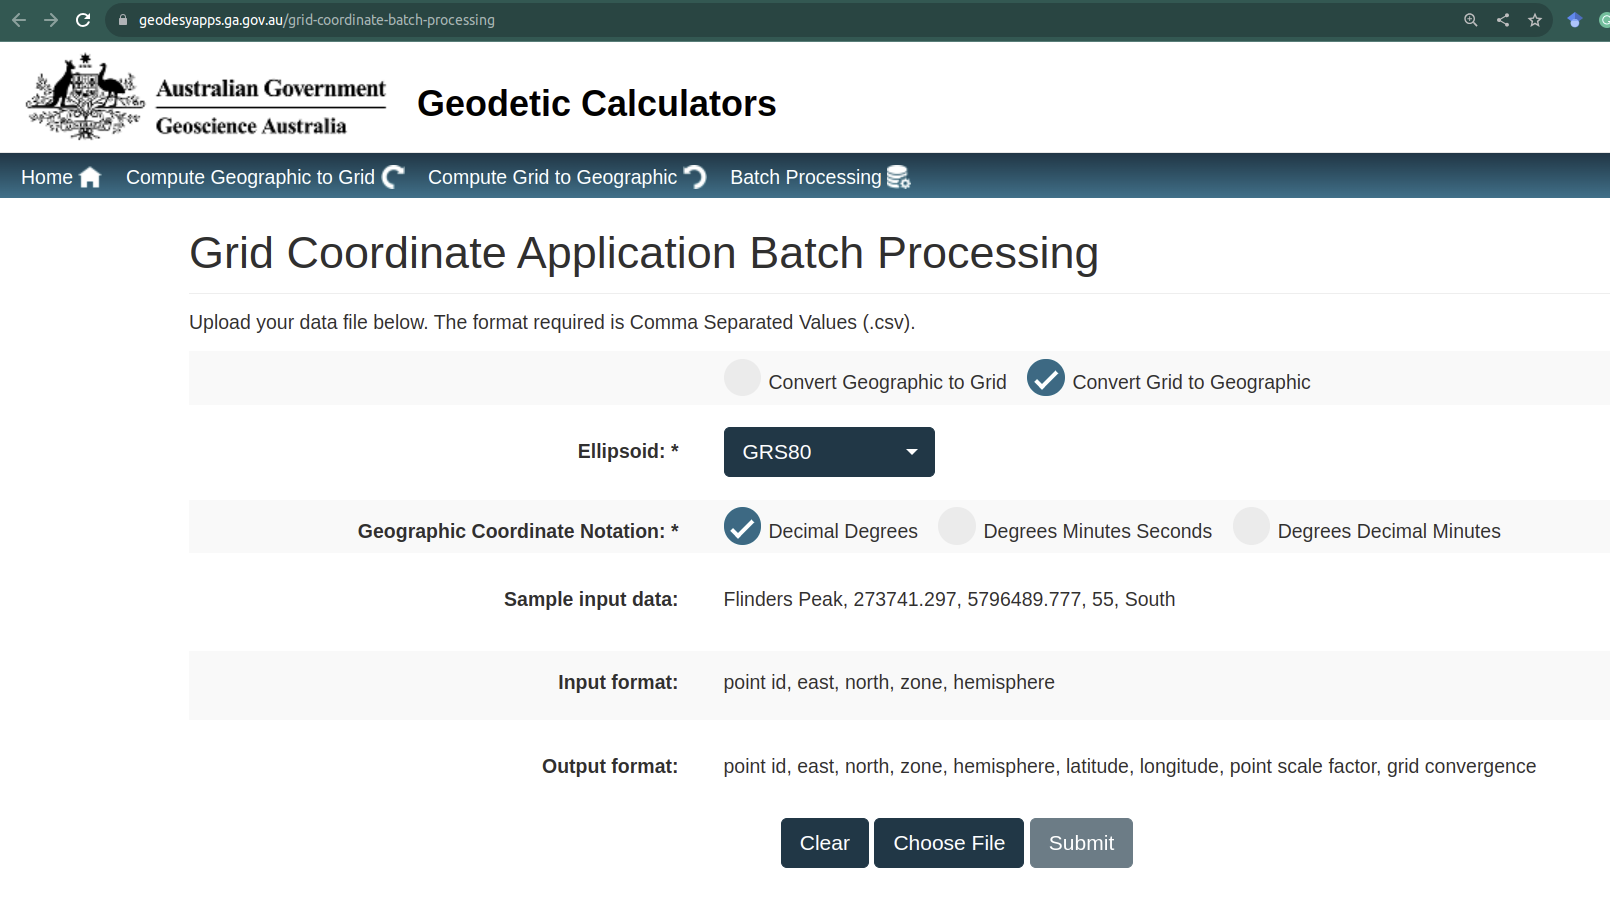

### Load the grid converted data (Lattitude/Longitude)
 
Open the transformed dataset and add elevation information back to this file for further processing.
 
    'GridConversion.csv' should be replaced with the actual filename or the full path to the CSV file you downloaded from GA Dataprocesor website in previous step.

    sep=',' specifies the separator used in the CSV file. In this case, it's a comma.

    header=0 indicates that the first row of the CSV file should be treated as the header containing column names.



In [ ]:
lat_long_data=pd.read_table('data/GridConversion.csv', sep=',', header=0)
mesh_data['lat'] = lat_long_data['lat']
mesh_data['lon'] = lat_long_data['lon']
mesh_data['corr_elevation'] = mesh_data['ellipsoidal height 2']
mesh_data.loc[mesh_data['corr_elevation']<0,'corr_elevation']=0.1
mesh_data.head()

### Clean the data to remove any unnecessary points from the dataset

We remove the first 20 points as they were the test points

In [ ]:
mesh_data = mesh_data[20:]


## Step 3: Access and Work with the Data

Now that you've loaded the data into the 'mesh_data' DataFrame, you can perform various operations on the data, such as data cleaning, analysis, visualization, and more using Pandas functions.

Firstly lets see the data that we are working on, with a simple scatter plot on top of a georeferenced map to put that data into context.


In [ ]:
# Create scatter map
fig = px.scatter_geo(mesh_data, lat='lat', lon='lon', color='corr_elevation',size = 'corr_elevation', hover_name='point id',title='Elevation')

#fig = px.line_geo(lat=mesh_data.lat, lon=mesh_data.lon)

fig.update_geos(fitbounds="locations")
fig.update_layout(height=400, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Plot the data on a Map

Create a scatter map on a Mapbox map, where each data point is represented by a marker (bubble). 

The size and color of each point are determined by the 'corr_elevation' variable. 

In [ ]:

fig = px.scatter_mapbox(mesh_data, lat = 'lat', lon = 'lon', 
                        color = 'corr_elevation', color_continuous_scale = 'plasma',
                        center = dict(lat = -23.5063, lon = 152.091), opacity=0.7,
                        zoom = 15, mapbox_style = 'open-street-map')

#fig.write_image("bubble-map-plotly.png", width = 800, height = 500)                        
fig.show()

## Create 3d Surface with the given points

We calculate the minimum and maximum latitude and longitude values from the mesh_data DataFrame. These values are used to define the extent of our grid.

We extract the 'lat' and 'lon' columns from the mesh_data DataFrame and convert them into NumPy arrays, which will be used as our scattered point data.

You also extract the 'corr_elevation' values from the mesh_data DataFrame and convert them into a NumPy array, which will be used as the values associated with the scattered points.

FInally, we use matplotlibs interpolate module to interpolate elevation values for the entire grid. The method='linear' argument specifies linear interpolation. This means it will estimate elevation values at the grid points based on the nearby scattered data points.

In [ ]:

np.random.seed(19680801)
npts = 200
ngridx = 1000
ngridy = 1000



min_lat, max_lat = mesh_data.lat.min(), mesh_data.lat.max()
min_lon, max_lon = mesh_data.lon.min(), mesh_data.lon.max()

x = mesh_data[['lat']].to_numpy().ravel()
y = mesh_data[['lon']].to_numpy().ravel()
z = mesh_data[['corr_elevation']].to_numpy().ravel()

# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
xi = np.linspace(min_lat, max_lat, ngridx)
yi = np.linspace(min_lon, max_lon, ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)

interp_lin = tri.LinearTriInterpolator(triang, z)
zi_lin = interp_lin(Xi, Yi)

interp_cubic_geom = tri.CubicTriInterpolator(triang, z, kind='geom')
zi_cubic_geom = interp_cubic_geom(Xi, Yi)

interp_cubic_min_E = tri.CubicTriInterpolator(triang, z, kind='min_E')
zi_cubic_min_E = interp_cubic_min_E(Xi, Yi)

# Set up the figure
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
axs = axs.flatten()

# Plot the triangulation.
f = axs[0].tricontourf(triang, z, cmap="plasma")
axs[0].triplot(triang, 'ko-')
axs[0].set_title('Triangular grid')

# Plot linear interpolation to quad grid.
f1 = axs[1].contourf(xi, yi, zi_lin, cmap="plasma")
#axs[1].plot(xi, yi, 'k-', lw=0.5, alpha=0.5)
axs[1].plot(x, y, 'ko', ms=1)
axs[1].contour(xi, yi, zi_lin, levels=3, linewidths=0.5, colors='k')
#axs[1].plot(xi.T, yi.T, 'k-', lw=0.5, alpha=0.5)
axs[1].set_title("Linear interpolation")

# Plot cubic interpolation to quad grid, kind=geom
f2 = axs[2].contourf(xi, yi, zi_cubic_geom, cmap="plasma")
#axs[2].plot(xi, yi, 'k-', lw=0.5, alpha=0.5)
axs[2].plot(x, y, 'ko', ms=1)
axs[2].contour(xi, yi, zi_cubic_geom, levels=3, linewidths=0.5, colors='k')
#axs[2].plot(xi.T, yi.T, 'k-', lw=0.5, alpha=0.5)
axs[2].set_title("Cubic interpolation,\nkind='geom'")

# # Plot cubic interpolation to quad grid, kind=min_E
# f3 = axs[3].contourf(xi, yi, zi_cubic_min_E, cmap="plasma")
# #axs[3].plot(xi, yi, 'k-', lw=0.5, alpha=0.5)
# axs[3].plot(x, y, 'ko', ms=1)
# axs[3].contour(xi, yi, zi_cubic_min_E, levels=3, linewidths=0.5, colors='k')
# #axs[3].plot(xi.T, yi.T, 'k-', lw=0.5, alpha=0.5)
# axs[3].set_title("Cubic interpolation,\nkind='min_E'")

plt.colorbar(f,ax=axs[0])
plt.colorbar(f1,ax=axs[1])
plt.colorbar(f2,ax=axs[2])
# plt.colorbar(f3,ax=axs[3])

fig.tight_layout()
plt.show()

We reshape the grid_z0 data from a 1D array with 1000x1000 elements into a 2D array with a shape of (1000, 1000). This is necessary to create a grid for the 3D surface plot.

We create a go.Figure object, which is used for creating Plotly plots.

Inside the go.Figure constructor, we add two go.Surface traces. The first go.Surface trace represents the elevation data, and the second go.Surface trace is used to create a shadow effect by adding a constant value to the elevation data (in this case, 3) and setting showscale to False. The opacity is set to 0.9 to control the transparency of the shadow surface.

In [ ]:

points = mesh_data[['lat','lon']].to_numpy()
values = mesh_data[['corr_elevation']].to_numpy()

grid_x, grid_y = np.mgrid[min_lat:max_lat:1000j, min_lon:max_lon:1000j]

grid_z0= griddata(points, values, (grid_x, grid_y), method='linear')



surface_data = grid_z0.reshape((1000,1000))
fig = go.Figure(data=[go.Surface(z=surface_data)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='One Tree Partial View', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

### Extract profile along any transect of the surface

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in meters (mean value)
    R = 6371000

    # Calculate the distance
    distance = R * c

    return distance


In [ ]:


def plot_2D_Elevation(position, mesh_data):
    
    min_lat, max_lat = mesh_data.lat.min(), mesh_data.lat.max()
    min_lon, max_lon = mesh_data.lon.min(), mesh_data.lon.max()
    
    points = mesh_data[['lat','lon']].to_numpy()
    values = mesh_data[['corr_elevation']].to_numpy()

    grid_x, grid_y = np.mgrid[min_lat:max_lat:1000j, min_lon:max_lon:1000j]

    grid_z0= griddata(points, values, (grid_x, grid_y), method='linear')



    surface_data = grid_z0.reshape((1000,1000))

    distance = haversine(min_lat, min_lon, min_lat, max_lon)
    corss_sec = np.nan_to_num(surface_data[position], nan=np.nan)
    labels = np.linspace(0, distance, 1000)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(labels, corss_sec,cmap='plasma',c=corss_sec)
    ax.set_title('Elevation Profile at \nLat =' + str(grid_x[position,0]) + " \nLon " + str(grid_y[position,0]))
    ax.set_ylabel("Elevation")
    ax.set_xticks((0, distance))
    ax.set_xticklabels(('$0$', str(distance)))

    ax.set_xlabel(f"The distance between the two points is approximately {distance:.2f} meters.")
    plt.show()


In [ ]:
position = 10
plot_2D_Elevation(position, mesh_data)

In [ ]:
position = 700
plot_2D_Elevation(position, mesh_data)